##순환 신경망 이해하기

완전연결 네트워크나 컨브넷처럼지금까지 본 모든 신경망의 특징은 메모리가 없다는 것입니다. 네트워크에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없습니다. 이런 네트워크로 시퀸스나 시계열 데이터 포인트를 처리하려면 네트워크에 전체 시퀸스를 주입해야 합니다. 즉 전체 시퀸스를 하나의 데이터 포인트로 변환해야 합니다. 예를 들어 IMDB문제에서 영화 리뷰하나를 큰 벡터 하나로 변환하여 처리했습니다. 이런 네트워크를 피드포워드 네트워크라고 합니다.

이와 반대로 사람이 문장을 읽는 것처럼 이저에 나온 것을 기억하면서 단어별로 또는 한눈에 들어오는 만큼씩 처리할 수 있습니다. 이는 문장에 있는 의미를 자연스럽게 표현하도록 도와줍니다. 생물학적 지능은 정보 처리를 위한 내부 모델을 유지하면서 점진적으로 정보를 처리합니다. 이 모델은 과거 정보를 사용하여 구축되며 새롭게 얻은 정보를 계속 업데이트 합니다.

비록 극단적으로 단순화시킨 버전이지만 순환신경망은 같은 원리를 적용한 것입니다. 시퀸스의 원소를 순회하면서 지금까지 처리한 정보를 상태에 저장합니다 사실 RNN은 내부에 루프를 가진 신경망의 한 종류입니다. RNN의 상태는 2개의 다른 시퀸스를 처리하는 사이에 재설정됩니다. 하나의 시퀴ㄴ스가 여전히 하나의 데이터 포인트로 간주됩니다. 즉 네트워크에 하나의 입력을 주입한다고 가정합니다. 이 데이터 포인트가 한 번에 처리되지 안흔다는 것이 다릅니다. 그 대신 네트워크는 시퀸스의 원소를 차례대로 방문합니다.

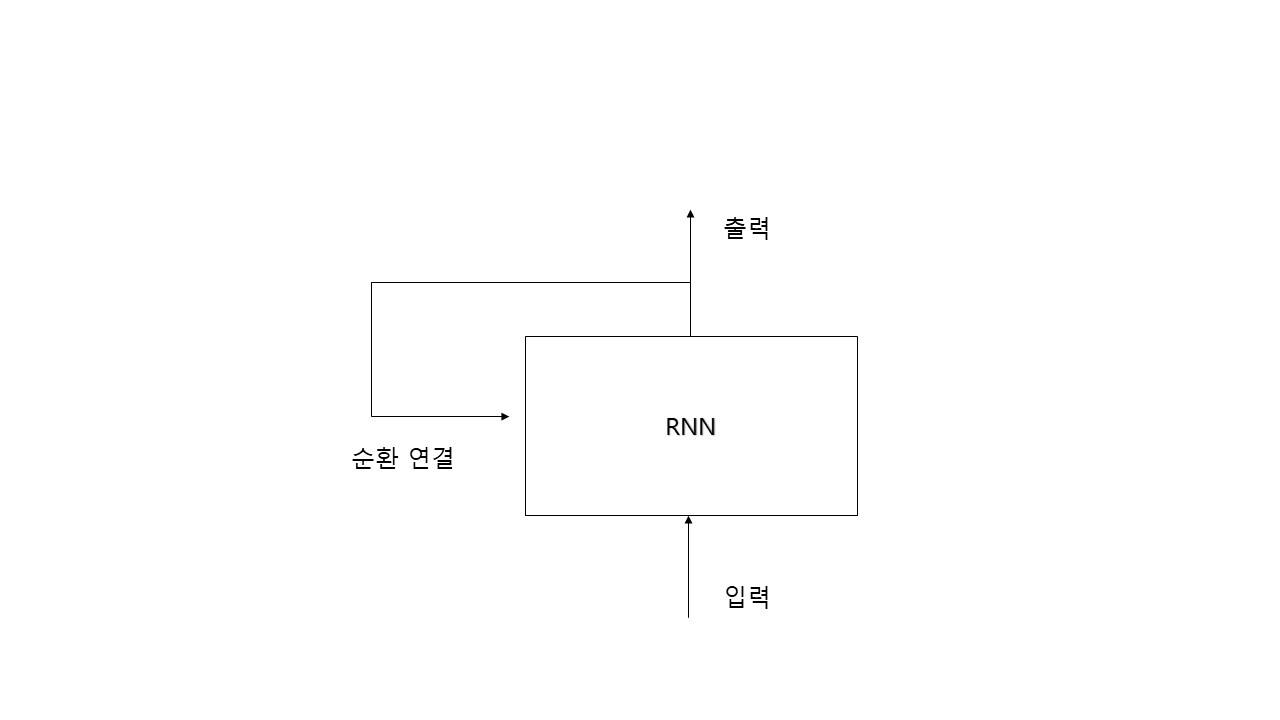

루프와 상태에 대한 개념을 명확히 하기 위해 넘파이로 간단한 RNN 정방향 계산을 구현해 보죠. 이 RNN은 크기가 (timesteps, input_features)인 2D텐서로 인코딩된 벡터의 시퀸스를 입력받습니다. 이 시퀸스는 타임스텝을 따라서 반복됩니다. 각 타임스텝 t에서 현재 상태와 ((input_features,)크기의) 입력을 연결하여 출력을 계산합니다. 그다음 이 출력을 다음 스텝의 상태로 설정합니다. 첫 번째 타임스텝에서는 이전 출력이 정의되지 않으므로 현재상태가 없습니다. 이때는 네트워크의 초기상태인 0벡터로 상태를 초기화힙니다.

의사코드로 표현하면 RNN은 다음과 같습니다.

In [ ]:
state_t = 0
for input_t in input_sequence:    #시퀸스의 원소를 반복합니다.
  output_t = f(input_t, state_t)
  state_t= output_t   #출력은 다음 반복을 위한 상태가 됩니다.

f함수는 입력과 상태를 출력으로 변환합니다. 이를 2개의 행렬 W와 U 그리고 편향 벡터를 사용하는 변환으로 바꿀 수 있습니다. 피드포워드 네트워크의 완전 연결 층에서 수행되는 변환과 비슷합니다.

In [ ]:
state_t = 0
for input_t in input_sequence:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t

완벽하게 설명하기 위해 간단한 RNN의 정방향 계산을 넘파이로 구현해 보죠.

In [14]:
import numpy as np

timesteps = 100     #입력 시퀸스에 있는 타임스텝 수
input_features = 32   # 입력 특성의 차원
output_features = 64   # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features))   #입력 데이터: 예제를 위해 생성한 난수

state_t = np.zeros((output_features,))    # 초기상태 : 모두 0인 벡터

#랜덤한 가중치 행렬을 만듭니다.
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:   #input_t는 크기가(input_features,)인 벡터입니다.
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t)+ b)

  successive_outputs.append(output_t)   # 이 출력을 리스트에 저장합니다.

  state_t = output_t   #다음 타임스텝을 위해 네트워크 상태를 업데이트합니다.

final_output_sequence = np.stack(successive_outputs, axis = 0)   #최종 출력은 크기가(timesteps, output_features)인 2D텐서입니다.

아주 쉽네요. 요약하면 RNN은 반복할 때 이전에 계산한 정보를 재사용하는 for 루프에 지나지 않습니다. 물론 이 정의에 맞는 RNN종류는 많습니다. 이 예는 가장 간단한 RNN의 현태입니다. RNN은 스텝 함수에 의해 특화됩니다. 이 예에서는 다음과 같습니다.

output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t)+ b)

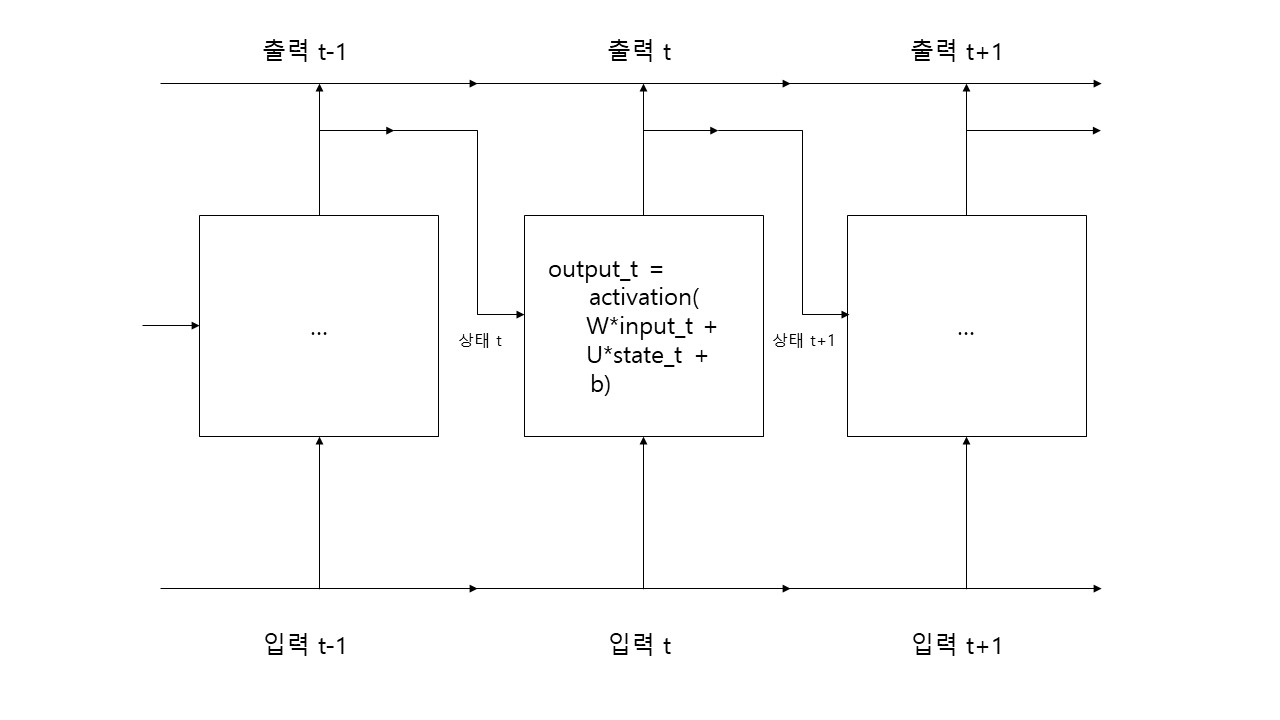

##케라스의 순환 층

넘파이로 간단하게 구현한 과정이 실제 케라스의 SimpleRNN층에 해당합니다.

In [15]:
from keras.layers import SimpleRNN

SimpleRNN이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀸스가 아니라 다른 케라스 층과 마찬가지로 시퀸스 배치를 처리한다는 것입니다. 즉(timesteps. input_features)크기가 아니라 (batch_size, timesteps, input_features)크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 마찬가지로 SimpleRNN은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀸스를 반환하거나(크기가 (batch_size, timesteps, output_features)인 3D 텐서), 입력 시퀸스에 대한 마지막 출력만 반환할 수 있습니다(크기가(batch_size, output_features)인 2D 텐서). 이 모드는 객체를 생성할 떄 return_sequences 매개변수로 선택할 수 있습니다. SimpleRNN을 사용하여 마지막 타임스텝의 출력만 얻는 예제를 살펴 보죠.

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


다음 예는 전체 상태 시퀸스를 반환합니다.

In [17]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간층들이 전체 출력 시퀸스를 반환하도록 설정해야 합니다.

In [18]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다.

In [19]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


Embedding층과 SimpleRNN 층을 사용하여 간단한 순환 네트워크를 훈련시켜 보겠습니다.

In [20]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 26s 155ms/step - loss: 0.6312 - acc: 0.6325 - val_loss: 0.5078 - val_acc: 0.7628
Epoch 2/10
157/157 [==============================] - 24s 152ms/step - loss: 0.3790 - acc: 0.8474 - val_loss: 0.5659 - val_acc: 0.7646
Epoch 3/10
157/157 [==============================] - 24s 153ms/step - loss: 0.2966 - acc: 0.8841 - val_loss: 0.3656 - val_acc: 0.8568
Epoch 4/10
157/157 [==============================] - 24s 153ms/step - loss: 0.2244 - acc: 0.9148 - val_loss: 0.5313 - val_acc: 0.8312
Epoch 5/10
157/157 [==============================] - 24s 153ms/step - loss: 0.1941 - acc: 0.9267 - val_loss: 0.3712 - val_acc: 0.8706
Epoch 6/10
157/157 [==============================] - 24s 153ms/step - loss: 0.1344 - acc: 0.9518 - val_loss: 0.5184 - val_acc: 0.7734
Epoch 7/10
157/157 [==============================] - 24s 154ms/step - loss: 0.0897 - acc: 0.9716 - val_loss: 0.4681 - val_acc: 0.8198
Epoch 8/10
157/157 [==============================] - 2

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다

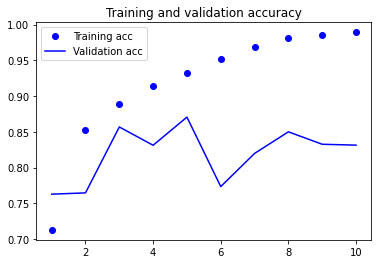

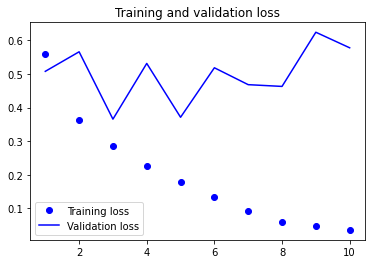

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝니만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀸스가 아니라 순서대로 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 SimpleRNN이 텍스트처럼 긴 시퀸스를 처리하는 데 적합하지 않기 때문입니다.  더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴 보죠.

##LSTM과 GRU 층 이해하기

케라스에서는 SimpleRNN 외에 다른 순환 층도 있습니다. LSTM과 GRU 2개입니다. 실전에서는 항상 이 둘중에 하나를 사용할 것입니다. SimpleRNN은 실전에 쓰기에는 너무 단순하기 때문입니다. SimpleRNN은 이론적으로 시간 T에서 이전의 모든 타임스텝의 정보를 유지할 수 있습니다. 실제로는 긴 시간에 걸친 의존성은 학습할 수 없는 것이 문제입니다. 층이 많은 일반 네트워크(피드포워드 네트워크)에서 나타나는 것과 비슷한 현상인 그래디언트 소실문제 때문입니다. 피드포워드 네트워크에 층을 많이 추가할수록 훈련하기 어려운 것과 같습니다. 1990년대 초 호크라이터, 슈미트후버, 벤지오가 이런 현상에 대한 이론적인 원인을 연구했습니다. 이 문제를 해결하기 위해 고안된 것이 LSTM과 GRU 층입니다.

LSTM 층을 살펴보죠. 장, 단기 메모리 알고리즘은 호크라이터와 슈미트후버가 1997년에 개발했습니다. 이 알고리즘은 그래디언트 소실 문제에 대한 연구의 결정체입니다.

이 층은 앞서 보았던 SimpleRNN의 한 변종입니다. 정보를 여러 타임스텝에 걸쳐 나르는 방법이 추가됩니다. 처리할 시퀸스에 나란히 작동하는 컨베이어 벨트를 생각해 보세요. 시퀸스 어느 지점에서 추출된 정보가 컨베이어 벨트 위로 올라가 필요한 시점의 타임스탭으로 이동하여 떨굽니다. 이것이 LSTM이 하는 일입니다. 나중을 위해 정보를 저장함으로써 처리 과정에서 오래된 시그널이 점차 소실되는 것을 막아줍니다.

이를 자세하게 이해하기 위해 SimpleRNN셀 부터 그려 보겠습니다. 가중치 행렬 여러 개가 나오므로 출력을 나타내는 문자 o로 셀에 있는 W와 U 행렬을 표현하겠습니다.

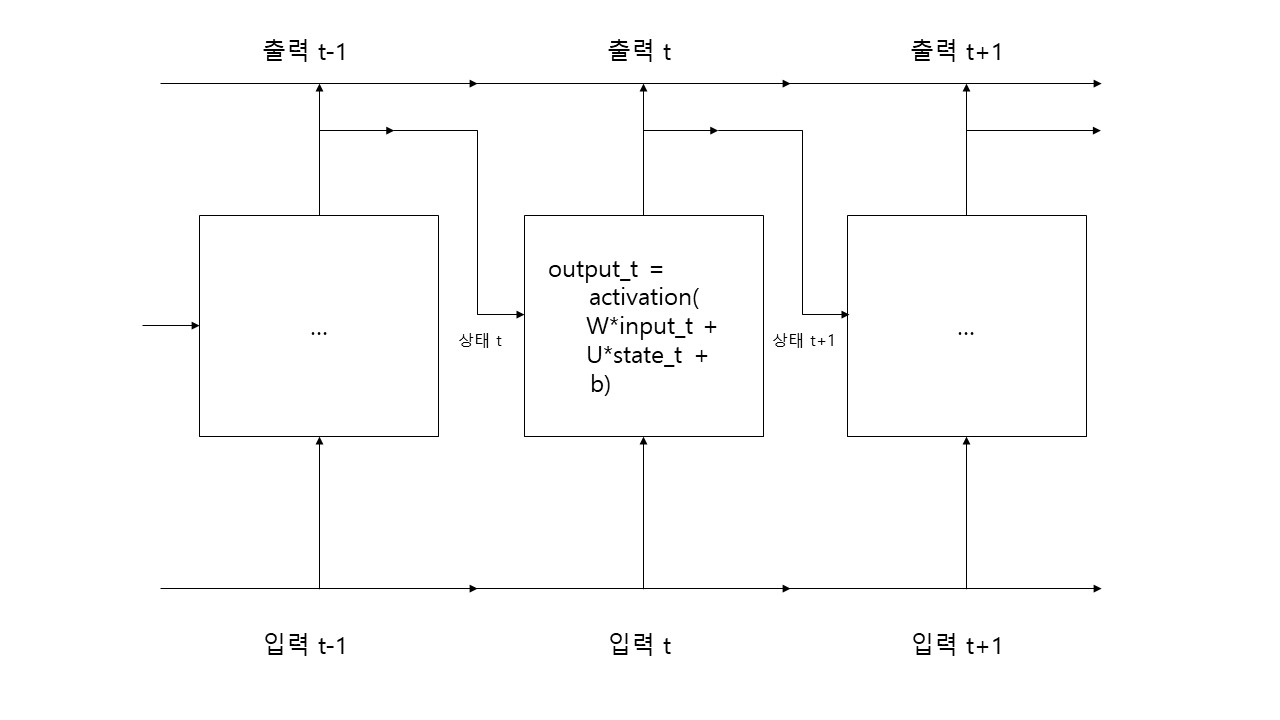

이 그림에 타임스텝을 가로질러 정보를 나르는 데이터 흐름을 추갛 보조. 타임스템 t에서 이값을 이동상태 c_t라고 부르겠습니다. 여기서 c는 이동을 의미합니다. 이 정보를 사용하여 셀이 다음과 같이 바뀝니다. 입력 연결과 순환연결로부터 이 정보가 합성됩니다(완전 연결층과 같은 변환: 가중치 행렬과 점곱한 후 편향을 더하고 활성화 함수를 적용합니다). 그러고는 다음 타음스텝으로 전달될 상태를 변경시킵니다(활성화 함수와 곱셈을 통해서). 개념적으로 보면 데이터를 실어 나르는 이 흐름이 다음 출력과 상태를 조절합니다. 여기까지는 간단합니다.

SimpleRNN에서 LSTM으로: 이동 트랙 추가

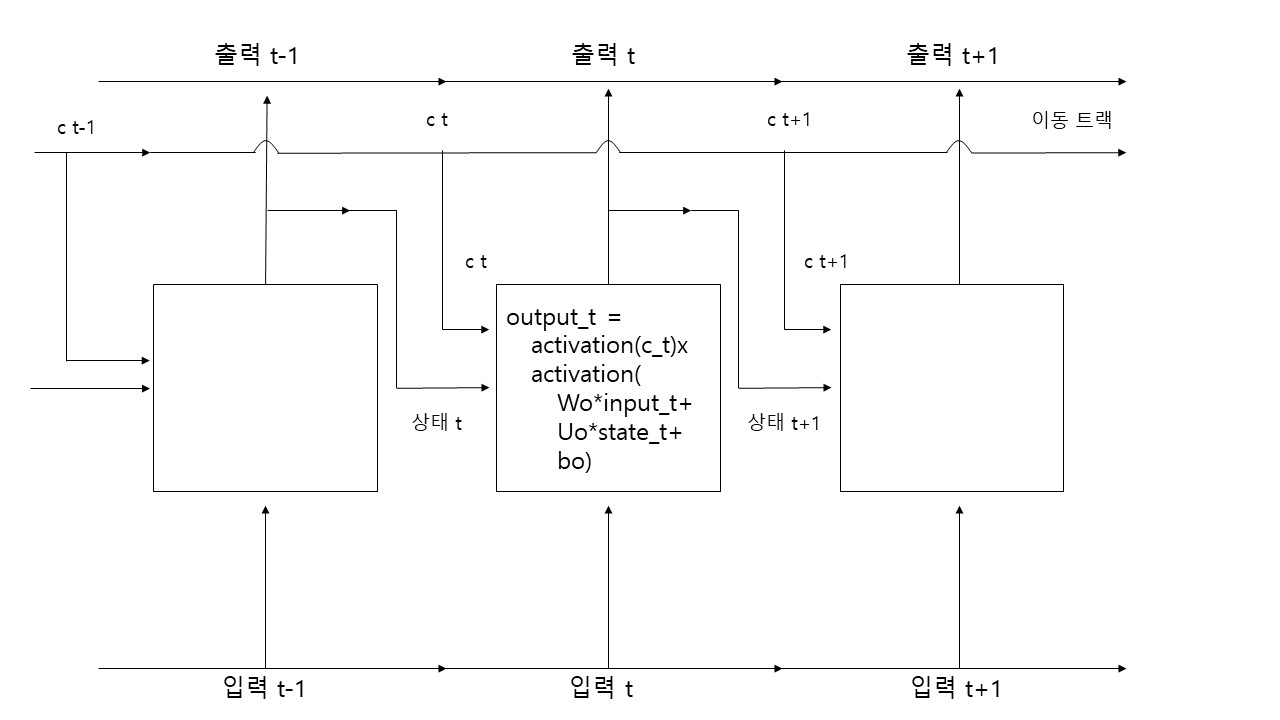

이제 복잡한 부분은 데이터 흐름에서 다음 이동 상태(c_t+1)가 계산되는 방식입니다. 여기에는 3개의 다른 변환이 관련되어 있습니다. 3개 모두 SimpleRNN과 같은 형태를 가집니다

y = activation(dot(state_t, U)+ dot(input_t, W)+b)

3개의 변환 모두 자신만의 가중치 행렬을 가집니다. 각각 i, f, k로 표시하겠습니다. 다음이 지금 까지 설명한 내용입니다(약간 이상하게 ㅗㅂ일 수 있지만 곧 설명하니 조금만 기다려 주세요).

In [ ]:
output_t = activation(c_t)*activation(dot(input_t, Wo) + dot(state_t, Uo)+ bo)

i_t = activation(dot(state_t, Ui)+ dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf)+ dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk)+ dot(input_t, Wk) + bk)

i_t, f_t, k_t를 결합하여 새로운 이동 상태(c_t+1)를 구합니다.

In [ ]:
c_t + 1 = i_t*k_t + c_t*f_t

밑에 이를 추가했습니다. 이것이 전부 입니다. 아주 복잡하지 않네요 조금 까다로울 뿐입니다.

LSTM 구조

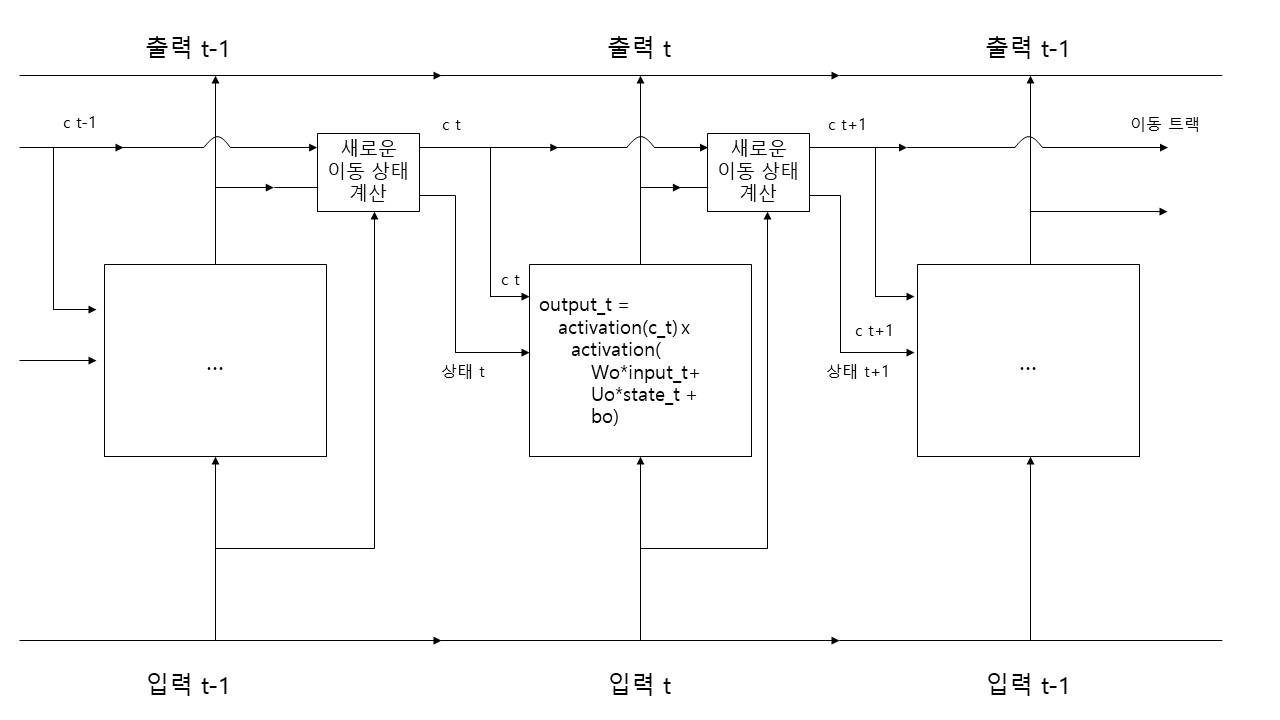

이 연산들이 하는 일을 해석하면 각 의미에 대해 통찰을 얻을 수 있습니다. 예를 들어 c_t와 f_t의 곱셈은 이동을 위한 데이터 흐름에서 관련이 적은 정보를 의도적으로 삭제한다고 볼 수 있습니다. 한편 i_t와 k_t는 현재에 대한 정보를 제공하고 이동 트랙을 새로운 정보로 업데이트합니다. 하지만 결국 이런 해석은 큰 의미가 없습니다. 이 연산들이 실제로 하는 일은 연산에 관련된 가중치 행렬에 따라 결정되기 떄문입니다. 이 가중치는 엔드-투-엔드 방식으로 학흡됩니다. 이 과정은 훈련 반복마다 매번 새로 시작되며 이런저런 연산들에 특정 목적을 부여하기가 불가능합니다. RNN셀의 사양은 가설 공간을 결정합니다. 훈련할 떄 이 공간에서 좋은 모델 파라미터를 찾습니다. 셀의 사양이 셀이 하는 일을 결정하지 않습니다. 이는 셀의 가중치에 달려 있습니다. 같은 셀이ㅓ라도 다른 가중치를 가지는 경우 매우 다른 작업을 수행합니다. 따라서 RNN 셀을 구성하는 연산 조합은 엔지니어링적인 설계가 아니라 가설 공간의 제약 조건으로 해석하는 것이 낫습니다.

연구자에게는 RNN 셀의 구현 방법 같은 제약 조건의 선택을 엔지니어보다(유전 알고리즘에 맡기면 더 나아 보일 것입니다. 미래에는 이런 식으로 네트워크를 만들게 될 것입니다. 요약하면 LSTM 셀의 구체적인 구조에 대해 이해할 필요가 전혀 없습니다. 우리가 해야 할 일도 아닙니다. LSTM 셀의 역할만 기억하면 됩니다. 바로 과거 정보를 나중에 다시 주입하여 그래디언트 소실 문제를 해결하는 것입니다.

##케라스를 사용한 LSTM 예제

이제 실제적인 관심사로 이동해보죠. LSTM 층으로 모델을 구성하고 IMDB데이터에서 훈련해 보겠습니다. 이 네트워크는 조금 전 SimpleRNN을 사용했던 모델과 비슷합니다. LSTM층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느 정도 작동하는 모델을 얻을 수 있습니다.

In [22]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 56s 334ms/step - loss: 0.6002 - acc: 0.6844 - val_loss: 0.4365 - val_acc: 0.8238
Epoch 2/10
157/157 [==============================] - 52s 329ms/step - loss: 0.3064 - acc: 0.8853 - val_loss: 0.3311 - val_acc: 0.8650
Epoch 3/10
157/157 [==============================] - 52s 329ms/step - loss: 0.2333 - acc: 0.9173 - val_loss: 0.2954 - val_acc: 0.8826
Epoch 4/10
157/157 [==============================] - 52s 330ms/step - loss: 0.1943 - acc: 0.9302 - val_loss: 0.3115 - val_acc: 0.8884
Epoch 5/10
157/157 [==============================] - 51s 327ms/step - loss: 0.1728 - acc: 0.9394 - val_loss: 0.2919 - val_acc: 0.8800
Epoch 6/10
157/157 [==============================] - 52s 329ms/step - loss: 0.1498 - acc: 0.9430 - val_loss: 0.3301 - val_acc: 0.8642
Epoch 7/10
157/157 [==============================] - 52s 330ms/step - loss: 0.1378 - acc: 0.9516 - val_loss: 0.3104 - val_acc: 0.8790
Epoch 8/10
157/157 [==============================] - 5

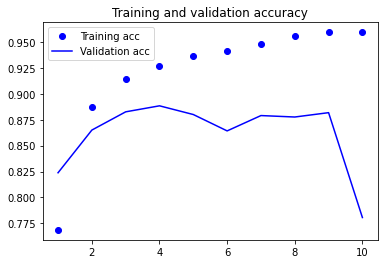

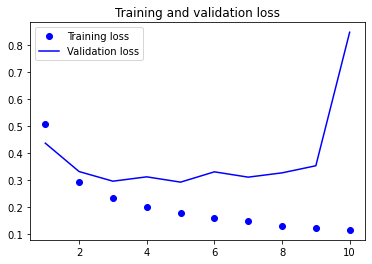

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이번에는 88% 정도의 검증 정확도를 달성했습니다. 나쁘지 않네요. SimpleRNN 네트워크보다 확실히 더 낫습니다. LSTM이 그래디언트 소실 문제로부터 덜 영향을 받기 때문입니다. 3장에서 사용했던 것보다 적은 데이터를 사용하고도 3장의 완전 연결 네트워크보다 조금 더 낫습니다. 3장에서는 전체 시퀸스를 사용했지만 여기서는 500 타임스텝 이후의 시퀸스를 잘라버렸습니다.

하지만 많은 계산을 사용한 것치고 획기적인 결과는 아닙니다. 왜 LSTM의 성능이 더 높지 않을까요? 한 가지 이유는 임베딩 차원이나 LSTM출력 차원 같은하이퍼파라미터를 전혀 튜닝하지 않았기 때문입니다. 또 하나는 규제가 없기 떄문입니다. 솔직히 말하면 가장 큰 이유는 리뷰를 전체적으로 길게 분석하는 것(LSTM이 잘하는 일)은 감성 분류 문제에 도움이 되지 않기 때문입니다. 이런 간단한 문제는 각 리뷰에 어떤 단어가 나타나고 얼마나 등장하는지를 보는 것이 낫습니다. 바로 첫 번째 완전 연결 네트워크가 사용한 방법입니다. 하지만 훨씬 더 복잡한 자연어 처리 문제들에서는 LSTM 능력이 드러납니다. 특히 질문-응답과 기계번역 분야입니다.

##정리

이제 다음을 알게 되었습니다.

 * RNN이 무엇이고 동작하는 방법
 * LSTM이 무엇이고 긴 시퀸스에서 단순한 RNN보다 더 잘 작동하는 이유
 * 케라스의 RNN층을 사용하여 시퀸스 데이터를 처리하는 방법

 다음으로 RNN의 여러 고급 기능을 살펴보겠습니다. 이런 기능을 사용하면 딥러닝의 시퀸스 모델을 최대로 활용할 수 있습니다.